In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from huggingface_hub import notebook_login
import pandas as pd 
import numpy as np

# notebook_login()

class Config:
    csv_file = "Symptom2Disease.csv"
    

In [ ]:
data = pd.read_csv(Config.csv_file, index_col=0)
data = data.reset_index(drop=True)
labels = sorted({x for x in data.label}) # 对标签去重后排序
dict_ = {}
for i, label in enumerate(labels): # 把中文标签映射到数字
    dict_[label] = i
data['label'] = data['label'].map(dict_)
data.head(5)

,label,text
0,15,I have been experiencing a skin rash on my arm...
1,15,"My skin has been peeling, especially on my kne..."
2,15,I have been experiencing joint pain in my fing...
3,15,"There is a silver like dusting on my skin, esp..."
4,15,"My nails have small dents or pits in them, and..."


In [30]:
labels[:10]

['Acne',
 'Arthritis',
 'Bronchial Asthma',
 'Cervical spondylosis',
 'Chicken pox',
 'Common Cold',
 'Dengue',
 'Dimorphic Hemorrhoids',
 'Fungal infection',
 'Hypertension']

In [4]:
model = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-v0.1")
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-v0.1")

Loading checkpoint shards: 100%|██████████| 2/2 [01:13<00:00, 36.78s/it]


In [5]:
import torch 

with torch.no_grad():
    featurized_x = []
    for i, (y, x) in enumerate(data.values):
        ids = tokenizer.encode(x)
        tensor = torch.tensor(ids).to(model.device)
        features = model.get_input_embeddings()(tensor)  # (n_tokens, model_dim)
        featurized_x.append(features.float().mean(0).cpu().detach().numpy())
# concatenate sentence embeddings
# x[None]由于mean(0)返回的array是1维的，x[None]添加一个行维度，合并的时候按照axis=0合并
X = np.concatenate([x[None] for x in featurized_x], axis=0)  # (n_points, model_dim)


In [6]:
model.device

device(type='cpu')

In [7]:
X.shape

(1200, 4096)

In [9]:
X[:2]

array([[ 2.3728427e-04,  1.5188426e-04, -4.8857200e-04, ...,
         9.4393406e-05,  4.4807573e-04, -5.7801674e-04],
       [-6.6506519e-04,  6.2881198e-05, -5.3181220e-04, ...,
        -8.8351284e-04, -7.0687704e-04,  6.0776303e-05]], dtype=float32)

c:\Users\hoover\miniforge3\envs\llm\Lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Exception in thread Thread-16 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\hoover\miniforge3\envs\llm\Lib\threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "c:\Users\hoover\miniforge3\envs\llm\Lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\hoover\miniforge3\envs\llm\Lib\threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)

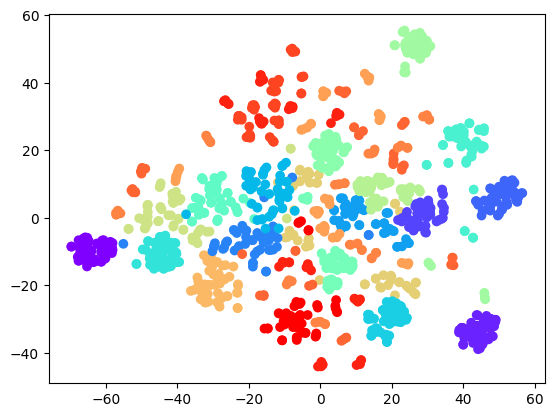

In [12]:
import sklearn
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from matplotlib.cm import rainbow

# This is a sanity check that our data clusters nicely
# map our feature space to 2D, plot it and color it by its labels

# integer class for each datapoint
data_class = list(data['label'])

reduced = sklearn.manifold.TSNE(n_components=2, random_state=0).fit_transform(X)
plt.scatter(reduced[:, 0], reduced[:, 1], c=data_class, cmap='rainbow')
plt.show()

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler



x_train,x_test, y_train, y_test = train_test_split(X, data_class, train_size=0.8, shuffle=True, random_state=10)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [43]:
from sklearn.linear_model import LogisticRegression

# For a real problem, C should be properly cross validated and the confusion matrix analyzed
clf = LogisticRegression(random_state=0, C=1.0, max_iter=500).fit(x_train, y_train)  # 98.33%

# you can also try the sag algorithm:
# clf = LogisticRegression(random_state=0, C=1.0, max_iter=1000, solver='sag').fit(train_x, train_y)

print(f"Precision: {100*np.mean(clf.predict(x_test) == y_test):.2f}%")

Precision: 98.33%


## 预测输入的文本

In [44]:
@torch.no_grad()
def classify(s: str):
    tokens = tokenizer.encode(s)
    tensor = torch.tensor(tokens).to(model.device)
    features = model.get_input_embeddings()(tensor)  # (n_tokens, model_dim)
    embedding = features.float().mean(0).cpu().detach().numpy()
    # print(embedding[None], scaler.transform(embedding[None]))
    embedding = scaler.transform(embedding[None])
    probas = clf.predict_proba(embedding)
    assert probas.shape == (1, len(labels))
    return probas[0]


sentence = "I have been feeling excessively hungry, even after eating, and have had a stiff neck."
probas = classify(sentence)

for i in np.argsort(probas)[::-1][:5]:
    print(f"{100*probas[i]:6.2f}%  {labels[i]}")

 99.91%  Migraine
  0.04%  gastroesophageal reflux disease
  0.02%  Arthritis
  0.01%  Cervical spondylosis
  0.01%  diabetes


## 其他传统多分类模型

In [41]:
from sklearn.svm import SVC


clf = SVC().fit(x_train, y_train)
print(f"Precision: {100*np.mean(clf.predict(x_test) == y_test):.2f}%")

Precision: 97.50%
